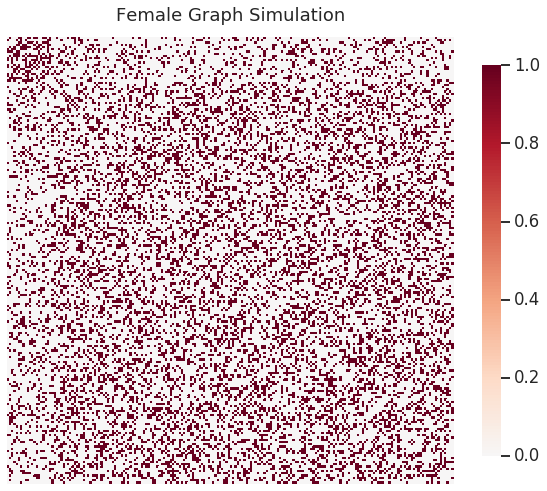

<Figure size 432x288 with 0 Axes>

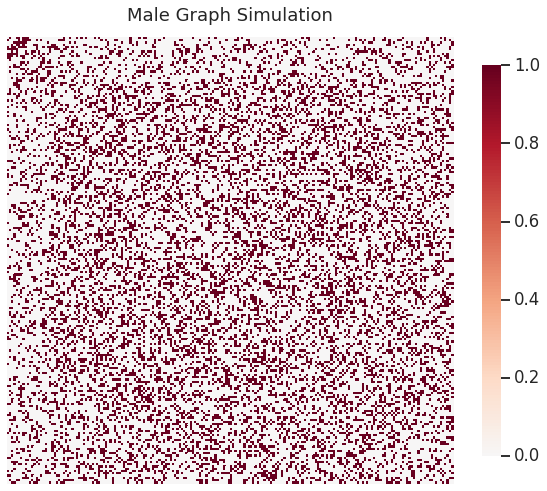

In [642]:
import graspy
from mgcpy.independence_tests.mgc import MGC
from mgcpy.independence_tests.dcorr import DCorr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
%matplotlib inline
from graspy.simulations import sbm
from graspy.plot import heatmap
np.random.seed(10)

#Generating simulation/test data
def data_generator(m_n_0, ss_m_n, p1, p2, p3, p4, p5, num_graphs):
    data = {}
    male = {}
    female = {}
    ind_male = 0
    ind_female = 0
    #This creates dictionaries of test data
    for i in range(0,num_graphs):
        n = [ss_m_n, m_n_0 - ss_m_n]
        if i % 2 == 0:
            p_male = [[p1, p2], [p3, p4]]
            male["male{0}".format(ind_male)] = sbm(n=n, p=p_male)
            data["male{0}".format(i)] = sbm(n=n, p=p_male)
            ind_male += 1
        else:
            p_female = [[p5, p2], [p3, p4]]
            female["female{0}".format(ind_female)] = sbm(n=n, p=p_female)
            data["female{0}".format(i)] = sbm(n=n, p=p_female)
            ind_female += 1
    return male,female,data

male, female, data = data_generator(200, 20, .30, .2, .2, .3, .45, 100)

#Plot
heatmap(female["female1"], title='Female Graph Simulation')

plt.figure()
heatmap(male["male1"], title='Male Graph Simulation')

#Uses L_class_tool on all entries in dictionary
def a_dict_to_p_dict(dict, dimvec, prob_mat_0, prob_mat_1, key_0, key_1, ss_n_m):
    dict_new = {}
    count = 0
    for key in dict:
        if key_0 in key:
            dict_new[key] = L_class_tool(dimvec, prob_mat_0, len(dict[key]), ss_n_m)
            count += 1
        else:
            dict_new[key] = L_class_tool(dimvec, prob_mat_1, len(dict[key]), ss_n_m)
            count += 1
    
    return dict_new   

# Expands probability matrices to have the dimensions of the adjacency matrices: makes
# [[0.3, 0.2], [0.2, 0.3]] into a 200 by 200 where the top left 100by100 are all 0.3, etc
def L_class_tool(dim_vec, p_matrix, dim_mat, SS_n):
    test_mat = sbm(n=dim_vec, p=p_matrix)
    val_0 = p_matrix[0][0]
    val_1 = p_matrix[0][1]
    val_2 = p_matrix[1][0]
    val_3 = p_matrix[1][1]
    for i in range(dim_mat):
        for j in range(dim_mat):
            if i < SS_n and j < SS_n:
                test_mat[i][j] = val_0
            elif i < SS_n and j > SS_n:
                test_mat[i][j] = val_1
            elif i > SS_n and j < SS_n:
                test_mat[i][j] = val_2
            else :
                test_mat[i][j] = val_3
    return test_mat

def classifier_method(num_graphs, num_graphs_0, num_graphs_1, P_hat_0, P_hat_1, vec, m_n_0, ss_m_n, A_mat):
    
    pi_coef_hat_0 = num_graphs_0 / num_graphs
    pi_coef_hat_1 = num_graphs_1 / num_graphs
    
    P_0 = L_class_tool(vec, P_hat_0, m_n_0, ss_m_n)
    P_1 = L_class_tool(vec, P_hat_1, m_n_0, ss_m_n)
    
    count = 1
    count_1 = 1
    for i in ss_m_n:
        for j in ss_m_n:
            prod = ((P_0[i][j])**(A_mat[i][j]))*((1 - P_0[i][j])**(1 - A_mat[i][j]))
            count = count * prod
            prod_1 = ((P_1[i][j])**(A_mat[i][j]))*((1 - P_1[i][j])**(1 - A_mat[i][j]))
            count_1 = count_1 * prod_1
    
    class_0 = pi_coef_hat_0 * count
    class_1 = pi_coef_hat_1 * count_1
    list_val = []
    list_val.append(class_0)
    list_val.append(class_1)
    return np.asarray(list_val)
    
def non_iterative_screen(a_dict, mat_n_m, y_labels, c, opt):

    '''
    Performs iterative screening on graphs.

    Parameters

    ----------
    
    a_dict: the dictionary of adjacency matrices are going to be used for signal subgraph.

    mat_n_m: Length/width of the adjacency matrices in the dictionary
    
    y_labels: the vector of labels.
    
    c: the correlation threshold value.
    
    opt: indicator of whether to use dcorr or mgc

    Returns

    -------

    values_flags: the signal subgraph of a_matrix, found through non-iterative

    vertex screening.
    '''
    mgc = MGC()
    dcorr = DCorr(which_test = 'unbiased')
    S_hat = np.zeros((mat_n_m,1))
    count = len(a_dict)
    bound = int(count / 2)
    
    #Creates matrices by stacking the nth rows on top of each other and running mgc on those with their 
    #corresponding labels.
    for i in range(mat_n_m):
      mat_hat = np.zeros((count,mat_n_m))
      for j in range(count):
        if j % 2 == 0:
          mat = a_dict["male{0}".format(j)]
        else:
          mat = a_dict["female{0}".format(j)]
        mat_hat[j] = mat[i]
      if opt == "mgc":
        c_u, independence_test_metadata = mgc.test_statistic(mat_hat, y_labels)
        S_hat[i][0] = c_u
      else:
        c_u, independence_test_metadata = dcorr.test_statistic(mat_hat, y_labels)
        S_hat[i][0] = c_u
    
    S_hat = np.absolute(S_hat)
    #as_vec = np.sort(S_hat.reshape(1,200)).reshape(200,1)
    #list_comp = as_vec[-20:]
    #values_flags = []
    #for i in range(20):
    #    values_flags.append(np.where(S_hat == list_comp[i])[0][0])
    print(S_hat)
    values_flags = np.nonzero(S_hat > c)    
    return values_flags
    
def vertex_diff(a_matrix_1, a_matrix_2):
    SS = []
    for i in range(len(a_matrix_1)):
        count = 0
        while count < len(a_matrix_1):
            if a_matrix_1[i][count] != a_matrix_2[i][count]:
                SS.append(i)
                count = len(a_matrix_1) + 1
            else:
                count += 1
    SS.sort()
    return SS

In [587]:
import sklearn.metrics as metrics
y_test = [0, 1]*50
y_test = np.asarray(y_test).reshape(100,1)
y_test = y_test.astype(float)
c = [10**-3, 10**-2, 0.1, 0.2, 0.5, 0.6, 0.7, 0.8, 0.9]
list_indices = [[]]
for c_val in c:
    list_indices.append(non_iterative_screen(data, 200, y_test, c_val))

In [588]:
#Signal sibgraphs generated for varying values of C
print(list_indices)

[[], (array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 105,
       106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118,
       119, 120, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132,
       133, 134, 136, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147,
       148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160,
       161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173,
       174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 1

In [589]:
#Code for making ROC curve later
mat_tests = [[.1, .2],
             [.2, .3]]
vec = [20, 180]
A_mat = sbm(n=vec, p=mat_tests)
list = []
for k in range(len(list_indices)):
    for key in data:
        list.append(np.argmax(classifier_method(100, 50, 50, .3, .2, .2, .3, .5, vec, 200, list_indices[k], data[key])))
list_test = [0, 1]*50
list_final = []
for i in range(len(list_test)):
    list_final.append(list[i] - list_test[i])


fpr, tpr, threshold = metrics.roc_curve(list_test, list)

plt.plot(fpr, tpr)

IndexError: index 194 is out of bounds for axis 0 with size 194

In [636]:
#Testing adjacency dictionary to probability dictionary
y_test = [0, 1]*50
y_test = np.asarray(y_test).reshape(100,1)
y_test = y_test.astype(float)
#c = 0.8
#iterative_screen(data, 200, y_test, c)
new_dict = a_dict_to_p_dict(data, [20, 180], [[0.3, 0.2], [0.2, 0.3]], [[0.45, 0.2], [0.2, 0.3]], "male", "female", 20)
print(new_dict)

{'male0': array([[0.3, 0.3, 0.3, ..., 0.2, 0.2, 0.2],
       [0.3, 0.3, 0.3, ..., 0.2, 0.2, 0.2],
       [0.3, 0.3, 0.3, ..., 0.2, 0.2, 0.2],
       ...,
       [0.2, 0.2, 0.2, ..., 0.3, 0.3, 0.3],
       [0.2, 0.2, 0.2, ..., 0.3, 0.3, 0.3],
       [0.2, 0.2, 0.2, ..., 0.3, 0.3, 0.3]]), 'female1': array([[0.3, 0.3, 0.3, ..., 0.2, 0.2, 0.2],
       [0.3, 0.3, 0.3, ..., 0.2, 0.2, 0.2],
       [0.3, 0.3, 0.3, ..., 0.2, 0.2, 0.2],
       ...,
       [0.2, 0.2, 0.2, ..., 0.3, 0.3, 0.3],
       [0.2, 0.2, 0.2, ..., 0.3, 0.3, 0.3],
       [0.2, 0.2, 0.2, ..., 0.3, 0.3, 0.3]]), 'male2': array([[0.3, 0.3, 0.3, ..., 0.2, 0.2, 0.2],
       [0.3, 0.3, 0.3, ..., 0.2, 0.2, 0.2],
       [0.3, 0.3, 0.3, ..., 0.2, 0.2, 0.2],
       ...,
       [0.2, 0.2, 0.2, ..., 0.3, 0.3, 0.3],
       [0.2, 0.2, 0.2, ..., 0.3, 0.3, 0.3],
       [0.2, 0.2, 0.2, ..., 0.3, 0.3, 0.3]]), 'female3': array([[0.3, 0.3, 0.3, ..., 0.2, 0.2, 0.2],
       [0.3, 0.3, 0.3, ..., 0.2, 0.2, 0.2],
       [0.3, 0.3, 0.3, ..., 0.2, 0.2,

In [645]:
#Displaying crap results
non_iterative_screen(data, 200, y_test, 0.8, "mgc")

[[7.58410942e-02]
 [6.01107427e-02]
 [7.25251450e-02]
 [5.65199925e-02]
 [3.35711260e-02]
 [5.83142462e-02]
 [6.11704403e-02]
 [6.22901787e-02]
 [4.24805990e-02]
 [6.77852344e-02]
 [4.43904607e-02]
 [1.03808200e-01]
 [2.79268150e-02]
 [3.16688387e-02]
 [2.16132911e-02]
 [3.76327261e-02]
 [5.75804790e-02]
 [3.83922680e-02]
 [3.75746093e-02]
 [3.12015127e-02]
 [2.68869106e-02]
 [2.79533477e-02]
 [2.46513431e-03]
 [1.17055775e-02]
 [1.87232930e-02]
 [2.50423144e-02]
 [2.62023846e-03]
 [4.40760556e-03]
 [2.98940672e-02]
 [3.08854232e-02]
 [1.51573772e-02]
 [7.27938452e-03]
 [4.80547040e-03]
 [7.97977743e-03]
 [4.11862810e-03]
 [2.18238675e-02]
 [5.76828248e-02]
 [1.49362964e-02]
 [1.60236263e-02]
 [2.73149175e-03]
 [6.05792005e-03]
 [8.29210290e-03]
 [5.74940348e-03]
 [2.47234590e-02]
 [3.03032655e-04]
 [1.47410180e-02]
 [8.33802635e-03]
 [3.38640471e-03]
 [8.95990617e-03]
 [2.36574187e-03]
 [6.03629266e-03]
 [1.41847237e-02]
 [1.48001459e-02]
 [1.80327114e-03]
 [3.24951236e-02]
 [2.876097

(array([], dtype=int64), array([], dtype=int64))

In [627]:
#Testing mgc works
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt; plt.style.use('classic')
import matplotlib.ticker as ticker
import seaborn as sns; sns.set(style="white")

from mgcpy.independence_tests.mgc import MGC
from mgcpy.benchmarks import simulations as sims

np.random.seed(12345678)

x, y = sims.linear_sim(num_samp=100, num_dim=1, noise=0.1)

print(x)
print(y)

mgc = MGC()
mgc_statistic, independence_test_metadata = mgc.test_statistic(x, y)
p_value, _ = mgc.p_value(x, y)

print("MGC test statistic:", mgc_statistic)
print("P Value:", p_value)

[[-0.50839153]
 [ 0.19285721]
 [-0.28241674]
 [-0.24217979]
 [-0.95109726]
 [-0.52338086]
 [-0.22413133]
 [ 0.36108209]
 [ 0.67868166]
 [ 0.52147377]
 [-0.5565168 ]
 [-0.87311677]
 [ 0.55888749]
 [ 0.44348274]
 [-0.61172231]
 [ 0.02292334]
 [-0.86239386]
 [-0.21171465]
 [ 0.96345533]
 [-0.39018298]
 [ 0.563918  ]
 [ 0.46941196]
 [ 0.67654318]
 [-0.75681979]
 [ 0.73567905]
 [ 0.12143119]
 [ 0.67334094]
 [ 0.47802897]
 [ 0.57147159]
 [ 0.36590989]
 [ 0.83062199]
 [-0.55482069]
 [ 0.1453687 ]
 [ 0.26051484]
 [-0.97321576]
 [-0.47439486]
 [ 0.46003151]
 [ 0.58172211]
 [-0.35070738]
 [-0.44671863]
 [-0.75406592]
 [-0.18023313]
 [ 0.90543377]
 [-0.52180368]
 [-0.97966436]
 [-0.96230593]
 [ 0.320034  ]
 [ 0.36565088]
 [ 0.40165202]
 [ 0.40111094]
 [ 0.26946797]
 [ 0.50916342]
 [ 0.09922972]
 [ 0.45068905]
 [ 0.33572805]
 [-0.85769373]
 [ 0.43030556]
 [ 0.25324764]
 [ 0.53297093]
 [ 0.38736645]
 [-0.09319562]
 [ 0.41946123]
 [-0.43952968]
 [ 0.74375816]
 [ 0.04410293]
 [ 0.52454403]
 [-0.02829